<a href="https://colab.research.google.com/github/troxlepa/MultiRegionPolicy/blob/main/MultiRegionPolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# specify whether you run this notebook in Colab or not
RUN_COLAB = True

# specify project root
if RUN_COLAB:
  BASE_PATH = "drive/MyDrive/MultiRegionPolicy/"
else:
  BASE_PATH = "YOUR_LOCAL_PATH"

# specify the number of scenario iterations (100 is default, takes ~3h on colab)
NUM_MULTI_RUNS = 20

# specify the number of samples in sensitivity anaylsis (1024 is default, takes ~6h on colab ; needs to be a multiple of 16)
SA_SAMPLE_SIZE = 16

In [ ]:
!pip install -q agentpy
!pip install -q ipywidgets
!pip install -q SAlib
!pip install -q matplotlib==3.1.3

In [3]:
# Model design
import agentpy as ap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.utils import io
import os
import json
from tqdm import tqdm
import csv
import statistics
from IPython.display import display, clear_output
import ipywidgets as ipy
import time
import pprint
import sys
from IPython.utils import io
import matplotlib.style as style
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy.stats as stats

# Model definition

In [4]:
#@title EconomicRegion
class EconomicRegion(ap.Agent):
  def setup(self):
    # constructed vars
    self.pid = 0
    self.eco_id = 0
    self.ctype = "E"

    # dynamically set
    self.D_0 = None
    self.D_tot = None
    self.E = None

    self.aK_S = None
    self.aP_S = None
    self.sG_S = None      # average S goal
    self.sD_S = None      # average S demand
    self.aPsi_S = None    # average market share (over all markets)

    self.aK_M = None      # average M competitiveness
    self.aP_M = None      # average M price
    self.sG_M = None      # average M goal
    self.sD_M = None      # average M demand
    self.aPsi_M = None    # average market share (over all markets)
    self.a_kappa_M = None # average M kappa
    self.aF_i_M = None    # average Fuel Inventory
    self.aX_M = None      # average number of adopted abatement options


    self.sM_M = None      # number of Manufacturers
    self.sE_G = None      # sum of global emissions
    self.sQ_S = None      # sum S fuel sales
    self.sQ_M = None      # sum M fuel sales

    # Policy Related
    self.sigma = 0                                  # taxes
    self.sigma_tot = self.p.sigma_tot[self.eco_id]  # final tax value
    self.t_start = self.p.t_start                   # starting step of policy
    self.t_impl = self.p.t_impl                     # gradual implementation duration

    self.q_h_sum = [0] * self.p.num_ecos            # Total Fuel Sales per ecoregion

    # Eval Metrics
    self.e_sum = 0  # sum of emissions
    self.e_var = 0  # variance of emissions

  def dynamicSetup(self):
    num_s = self.p.num_s[self.eco_id]
    num_m = self.p.num_m[self.eco_id]
    self.suppliers = ap.AgentList(self.model, num_s, Supplier, eco_id=self.eco_id)
    self.manufacturers = ap.AgentList(self.model, num_m, Manufacturer, eco_id=self.eco_id)
    self.suppliers.D = [self.p.D_SM_0] * self.p.num_ecos
    self.manufacturers.D = [self.p.D_SM_0] * self.p.num_ecos

  def precomp_E(self):
    self.E = []
    for i in range(self.p.num_ecos):
      Ei = 0
      for j in range(self.p.num_ecos):
        for m in self.model.ecoregions[i].manufacturers:
          Ei += m.kappa[j] * m.D[j] * m.psi[j]
      if Ei == 0:
        Ei = self.p.eps
      self.E.append(Ei)

  def update_policy(self):
    if self.model.t > self.t_start:
      self.sigma = self.sigma_tot * min(1,(self.model.t - self.t_start) / self.t_impl)

  def eval_metrics(self):
    # Total emissions
    self.e_sum = sum(self.manufacturers.emissions)
    self.e_var = np.var(np.array(self.manufacturers.emissions))
    self.sE_G = 0
    for i in range(self.p.num_ecos):
      eco = self.model.ecoregions[i]
      em = eco.manufacturers
      self.sE_G += sum(em.emissions)

    # Total fuel sales of the region
    self.sQ_S = 0
    for s in self.suppliers:
        self.sQ_S += sum(s.q_h)

    # Total goods sales of the region
    self.sQ_M = 0
    for m in self.manufacturers:
        self.sQ_M += sum(m.q_h)

  def calc_average_S(self,ctype):
    j = self.pid

    avg_C = lambda comp,vn : sum([c[vn][j] * c['psi'][j] for c in comp])
    sum_C = lambda comp,vn : sum([c[vn][j] for c in comp])
    w_avg_S = lambda vn : sum([avg_C(eco,vn) for eco in self.model.ecoregions.suppliers])
    w_sum_S = lambda vn : sum([sum_C(eco,vn) for eco in self.model.ecoregions.suppliers])

    if ctype == "k":
      self.aK_S = w_avg_S('k')
    elif ctype == "p_s":
      self.aP_S = w_avg_S('p_s')
    elif ctype == "psi":
      total_psi_S = 0
      self.aPsi_S = 0
      for i in range(self.p.num_ecos):
        s = self.model.ecoregions[i].suppliers
        for comp in s:
          total_psi_S += comp.psi[j]
        s = self.model.ecoregions[j].suppliers
        for comp in s:     
          self.aPsi_S += comp.psi[i] / self.p.num_ecos
    elif ctype == "D":
      self.sD_S = w_sum_S('D')
    elif ctype == "g":
      self.sG_S = w_sum_S('g')

  def calc_average_M(self,ctype):
    j = self.pid

    avg_C = lambda comp,vn : sum([c[vn][j] * c['psi'][j] for c in comp])
    sum_C = lambda comp,vn : sum([c[vn][j] for c in comp])
    w_avg_M = lambda vn : sum([avg_C(eco,vn) for eco in self.model.ecoregions.manufacturers])
    w_sum_M = lambda vn : sum([sum_C(eco,vn) for eco in self.model.ecoregions.manufacturers])

    if ctype == "k":
      self.aK_M = w_avg_M('k')
    elif ctype == "p_s":
      self.aP_M = w_avg_M('p_s')
    elif ctype == "psi":
      total_psi_M = 0
      self.aPsi_M = 0
      for i in range(self.p.num_ecos):
        m = self.model.ecoregions[i].manufacturers
        for comp in m:
          total_psi_M += comp.psi[j]
        m = self.model.ecoregions[j].manufacturers
        for comp in m:     
          self.aPsi_M += comp.psi[i] / self.p.num_ecos
    elif ctype == "D":
      self.sD_M = w_sum_M('D')
    elif ctype == "g":
      self.sG_M = w_sum_M('g')
    elif ctype == "kappa":
      self.a_kappa_M = w_avg_M('kappa')
    elif ctype == "num_m":
      self.sM_M = len(self.manufacturers)
    elif ctype == "f_i":
      self.aF_i_M = sum(self.manufacturers.f_i)
    elif ctype == "abatement_current":
      if len(self.manufacturers) > 0:
        self.aX_M = sum(self.manufacturers.abatement_current-1) / len(self.manufacturers)
      else:
        self.aX_M = 0   
    

  def consumer_market_total_demand(self):
    m = self.manufacturers
    s = self.suppliers
    j = self.pid

    # update demand
    self.D_tot = self.D_0 * np.exp(- self.p.mu * self.aP_M)


In [5]:
#@title Company
class Company(ap.Agent):
  def setup(self,eco_id):
    num_ecos = self.p.num_ecos

    # constructed vars
    self.pid = 0  
    self.eco_id = eco_id 
    self.ctype = "C"

    # static vars
    self.phi = [1.0/num_ecos]*num_ecos  # fraction of sales in economic regions
    self.q = [0.0]*num_ecos             # inventory
    self.l = [0.0]*num_ecos             # unfilled demand
    self.k = [None]*num_ecos            # competitiveness
    self.D = [0]*num_ecos               # demand

    # dynamic assignment
    self.g = [0]*num_ecos               # production goal
    self.dq = [None]*num_ecos           # production
    self.q_h = [None]*num_ecos          # actual sales
    self.psi = []                       # market shares
    self.psi_1 = []                     # t-1 market shares
    self.psi_2 = []                     # t-2 market shares
    self.A = None                       # fuel intensity
    self.B = None                       # production cost
    self.kappa = [None]*num_ecos        # margin
    self.D_exp = [None]*num_ecos        # demand
    self.p_s = [None]*num_ecos          # sales price

    # statistics
    self.emissions = 0                  # emissions


In [6]:
#@title Manufacturer
class Manufacturer(Company):
  def setup(self,eco_id):
    super().setup(eco_id)
    self.ctype = "M"

    self.d = [1.0 / self.p.S_tot] * self.p.S_tot          # supplier preference
    self.f_d = 0.0                                        # desired fuels
    self.f_i = 0.0                                        # fuels in inventory
    self.f_q = 0.0                                        # new fuels in current step
    self.f_pq = 0.0                                       # price of new fuels in current step 
    self.kappa = [self.p.kappa_0_M]*self.p.num_ecos       # margins
    self.psi = [1.0/sum(self.p.num_m)]*self.p.num_ecos    # market shares
    self.psi_1 = [1.0/sum(self.p.num_m)]*self.p.num_ecos  # t-1 market shares
    self.psi_2 = [1.0/sum(self.p.num_m)]*self.p.num_ecos  # t-2 market shares

    # abatement
    self.abatement_current = 1                            # number of next abatement option to be adopted
    self.abatement_a = self.p.ld / self.p.N_ld            # fuel intensity change
    self.abatement_a_sum = 0                              # sum of fuel intensity change
    self.abatement_bx_sum = 0                             # sum of productiuon cost change

    # relocation
    self.t_count_delay = 0                                # counter for delay before relocation
    self.t_count_stay = 0                                 # counter for staying before checking relocation
    self.target_eco_id = self.eco_id                      # target region for relocation

    # dynamic assignment
    self.c = 0.0                                          # average fuel cost

  def dynamicSetup(self):
    self.A_0 = self.p.A_0_M[self.eco_id][self.pid]        # initial fuel intensity
    self.B_0 = self.p.B_0_M[self.eco_id][self.pid]        # initial production cost
    self.A = self.A_0                                     # current fuel intensity
    self.B = self.B_0                                     # current production cost
    alpha = self.p.beta_params[self.eco_id][0]            # alpha parameter of beta-distribution
    beta = self.p.beta_params[self.eco_id][1]             # beta parameter of beta-distribution
    self.epsilon_1 = self.beta_dist(alpha,beta)           # abatement cost factor adjustment

  def beta_dist(self,a,b):
    return np.random.beta(a,b)

  # M1
  def set_goal(self):
    self.D_exp = self.D
    for i in range(self.p.num_ecos):
      val = (1+self.p.ql_d)*self.D_exp[i]-self.q[i]
      self.g[i] = max(0,val)

  # M2
  def calculate_desired_fuels(self):
    if self.model.t < 5:
      self.f_i = 0  
    sum_g = 0
    for i in range(self.p.num_ecos):
      sum_g += self.g[i]
    self.f_d = self.A * self.p.tau * sum_g - self.f_i
    if self.A * self.p.tau * sum_g + 0.001< self.f_i:
      self.f_d = 0

  # M3
  def place_orders(self):
    if self.f_d > 0:
      for i in range(self.p.num_ecos):
        eco_id = i
        for j in range(len(self.model.ecoregions[i].suppliers)):
          supplier_ij = self.model.ecoregions[i].suppliers[j]
          amt = self.f_d * self.d[supplier_ij.pid]
          supplier_ij.orders.append((self,amt))
  

  
  # M3.1
  def calc_avg_fuel_prices(self):
    if self.f_q > 0:
      self.c = self.f_pq / self.f_q

  # M3.2
  def reset_q_h(self):
    self.f_q = 0
    self.f_pq = 0

  # M4
  def production(self):
    #self.emissions = 0
    for i in range(self.p.num_ecos):
      production_limit = self.f_i * self.phi[i] / (self.p.tau * self.A)
      # calculate new goods
      self.dq[i] = min(self.g[i], production_limit)
      # add goods to inventory
      self.q[i] += self.dq[i]
      self.emissions += self.dq[i] * self.A
      
    # remove fuel from inventory
    for i in range(self.p.num_ecos):
      temp = self.f_i
      self.f_i -= self.A * self.dq[i]
      if np.abs(self.f_i) < self.p.eps:
        self.f_i = 0

  # M5
  def set_price(self):
    j = self.eco_id
    for i in range(self.p.num_ecos):
      if self.model.t > 1 and self.psi_2[i] > self.p.eps:
        self.kappa[i] *= 1 + self.p.vartheta * (self.psi_1[i] - self.psi_2[i]) / max(self.p.eps,self.psi_2[i])
      sigma = self.model.ecoregions[self.eco_id].sigma
      padd = (self.B + self.A * (sigma + self.c))
      self.p_s[i] = (1+self.kappa[i]) * (1+self.p.rho_M[self.eco_id][i]) * padd
      if(self.p_s[i] < 0):
        self.p_s[i] = 0

  # M6
  def calc_competitiveness(self):
    for i in range(self.p.num_ecos):
      self.k[i] = - self.p_s[i] - self.l[i]

  # M7
  def calc_market_share(self):
    for i in range(self.p.num_ecos):
      self.psi_2[i] = self.psi_1[i]
      self.psi_1[i] = self.psi[i]
      avg_M_comp = self.model.ecoregions[i].aK_M
      self.psi[i] = self.psi[i] * (1.0-self.p.chi_M*(self.k[i]-avg_M_comp)/avg_M_comp)
      self.psi[i] = max(0,self.psi[i])
      self.psi[i] = min(1,self.psi[i])

  # M8
  def compute_demand(self):
    for i in range(self.p.num_ecos):
      self.D[i] = self.model.ecoregions[i].D_tot * self.psi[i]

  # M9
  def compute_actual_sales(self):
    for i in range(self.p.num_ecos):
      self.q_h[i] = min(self.D[i],self.q[i])
      self.q_h[i] = max(0,self.q_h[i])
      self.l[i] = self.D[i] - self.q_h[i]
      self.q[i] -= self.q_h[i]

  # M10
  def fraction_sold(self):
    if self.model.t > 1:
      sum_q_h = 0
      for i in range(self.p.num_ecos):
        sum_q_h += self.q_h[i]
      if(sum_q_h <= 0):
        self.phi[i] = 0
      else:
        for i in range(self.p.num_ecos):
          self.phi[i] = self.q_h[i] / sum_q_h 

  # M11.1
  def check_relocation(self):
    if self.target_eco_id != self.eco_id: return
    if self.t_count_stay < self.p.t_stay:
      self.t_count_stay += 1
      return
    E = self.model.ecoregions[self.eco_id].E

    Em = 0
    for j in range(self.p.num_ecos):
      Em += self.kappa[j] * self.D[j]

    w = []
    for j in range(self.p.num_ecos):
      if j == self.eco_id:
        w.append(0)
        continue
      t1 = self.p.gamma * len(self.model.ecoregions[j].manufacturers) * self.p.num_ecos / sum(self.p.num_m)
      t2 = max(0,(E[j]-Em) / E[j])
      wji = t1 * t2
      w.append(wji)
    w = np.array(w)

    # no relocation if no better option
    if w.sum() < self.p.eps:
      return
    x = np.random.rand()
    threshold = min(self.p.xi, w.max())
    if x < threshold:
      normalized_w = w / w.sum()
      new_location_eco_id = np.random.choice(normalized_w.shape[0],1,p=normalized_w)[0]
      self.target_eco_id = new_location_eco_id
      self.t_count_delay = 0

  # M11.2
  def relocation(self):
    if self.target_eco_id == self.eco_id: return    
    if self.t_count_delay < self.p.t_delay:
      self.t_count_delay += 1
      return
    # delete manufacturer form old ecoregion
    self.model.ecoregions[self.eco_id].manufacturers.remove(self)
    # append manufacturer to new ecoregion
    self.model.ecoregions[self.target_eco_id].manufacturers.append(self)
    self.eco_id = self.target_eco_id
    # recalculate abatement options
    self.A_0 = self.p.A_0_M[self.eco_id][self.pid]
    self.B_0 = self.p.B_0_M[self.eco_id][self.pid]
    alpha = self.p.beta_params[self.eco_id][0]
    beta = self.p.beta_params[self.eco_id][1]
    self.epsilon_1 = self.beta_dist(alpha,beta)
    self.t_count_stay = 0

  # M12
  def abatement(self):
    if self.abatement_current > self.p.N_ld: return
    a = self.abatement_a
    epsilon = self.p.epsilon_0 + self.p.y * self.epsilon_1
    x = self.abatement_current
    omega = epsilon * a * x
    if omega * ( 1 + self.p.eta ) <= ( self.model.ecoregions[self.eco_id].sigma + self.c): 
      # taking abatement option
      bx = omega * a
      self.abatement_a_sum += a
      self.abatement_bx_sum += bx
      self.A = self.A_0 - self.abatement_a_sum
      self.A = max(self.A,self.p.eps)
      self.B = self.B_0 + self.abatement_bx_sum
      self.abatement_current += 1

  # M13
  def change_supplier(self):
    k_mean = 0
    for i in range(self.p.num_ecos):
      for j in range(len(self.model.ecoregions[i].suppliers)):
        supplier_ij = self.model.ecoregions[i].suppliers[j]
        supplier_ij_idx = supplier_ij.pid
        k_ij = self.model.ecoregions[i].suppliers[j].k[self.eco_id]
        k_mean += k_ij * self.d[supplier_ij_idx]

    d_sum = 0
    for i in range(self.p.num_ecos):
      for j in range(len(self.model.ecoregions[i].suppliers)):
        supplier_ij = self.model.ecoregions[i].suppliers[j]
        supplier_ij_idx = supplier_ij.pid
        k_ij = self.model.ecoregions[i].suppliers[j].k[self.eco_id]
        self.d[supplier_ij_idx] *= np.exp(self.p.chi_S * (k_ij - k_mean) / k_mean)   
        d_sum += self.d[supplier_ij_idx] 
             
    # renormalization of d
    self.d = self.d / d_sum
    for i in range(len(self.d)):
      if np.isnan(self.d[i]):
          self.d[i] = 0

  def check_validity(self):
    for i in range(self.p.num_ecos):
      assert self.dq[i] >= 0
      assert self.q[i] >= 0
      assert self.q_h[i] >= 0
      assert self.p_s[i] >= 0
      assert self.k[i] <= 0
      assert self.l[i] >= 0
      assert self.D[i] >= 0
      assert self.D_exp[i] >= 0



In [7]:
#@title Supplier
class Supplier(Company):

  def setup(self,eco_id):
    super().setup(eco_id)
    self.ctype = "S"
    self.orders = []
    self.kappa = [self.p.kappa_0_S]*self.p.num_ecos
    self.psi = [1.0/sum(self.p.num_s)]*self.p.num_ecos
    self.psi_1 = [1.0/sum(self.p.num_s)]*self.p.num_ecos # t-1 market shares
    self.psi_2 = [1.0/sum(self.p.num_s)]*self.p.num_ecos # t-2 market shares

  def dynamicSetup(self):
    self.B = self.p.B_0_S[self.eco_id][self.pid]

  # (S1)
  def set_goal(self):
    local_D = [0] * len(self.D)
    for obj, amt in self.orders:
      src_eco_id = obj.eco_id
      local_D[src_eco_id] += amt
    for i in range(self.p.num_ecos):
      self.D[i] = local_D[i]
      self.D_exp[i] = local_D[i]

    for i in range(self.p.num_ecos):
      self.g[i] = (1+self.p.ql_d)*self.D_exp[i]-self.q[i]
      self.g[i] = max(0,self.g[i])

  # (S2)
  def production(self):
    for i in range(self.p.num_ecos):
      self.dq[i] = self.g[i]
      self.q[i] += self.dq[i]
    self.B += self.p.zeta * sum(self.dq)

  # (S3)
  def set_price(self):
    for i in range(self.p.num_ecos):
      if self.model.t > 1 and self.psi_2[i] > self.p.eps:
        self.kappa[i] *= 1 + self.p.vartheta * (self.psi_1[i] - self.psi_2[i]) / max(self.p.eps,self.psi_2[i])
      self.p_s[i] = (1+self.kappa[i]) * (1+self.p.rho_S[self.eco_id][i]) * self.B
  
  # (S5)
  def sell_fuel(self):
    for i in range(self.p.num_ecos):
      if self.D_exp[i] > self.q[i] and self.D_exp[i] > 0:
        frac = self.q[i] / self.D_exp[i]
      else:
        frac = 1.0
    for order in self.orders:
      obj, amt = order
      q = amt * frac
      obj.f_i += q
      obj.f_q += q
      obj.f_pq += q * self.p_s[obj.eco_id]
      target_region = obj.eco_id
      self.q[target_region] -= q
    self.orders = []

  # (S6)
  def compute_actual_sales(self):
    for i in range(self.p.num_ecos):
      self.q_h[i] = min(self.D_exp[i],self.q[i]) # calculate actual sales
      self.l[i] = self.D_exp[i] - self.q_h[i] # calculate unfilled demand

  # (S7)
  def calc_market_share(self,q_h_sum):
    for i in range(self.p.num_ecos):
      self.psi_2[i] = self.psi_1[i]
      self.psi_1[i] = self.psi[i]
      if q_h_sum[i] > self.p.eps:
        self.psi[i] = self.q_h[i] / q_h_sum[i]
      self.psi[i] = max(0,self.psi[i])
      self.psi[i] = min(1,self.psi[i])

  # (S8)
  def calc_competitiveness(self):
    for i in range(self.p.num_ecos):
      self.k[i] = - self.p_s[i] - self.l[i]

In [8]:
 #@title Model

class Model(ap.Model):

    def setup(self, run_type=""):
        self.run_type = run_type
        self.ctype = "X"
        self.pid = 0
        # recursively create all agents
        self.ecoregions = ap.AgentList(
            self, self.p.num_ecos, EconomicRegion)
        
        # set constructed vars
        self.ecoregions.pid = ap.AttrIter(range(0,self.p.num_ecos))
        self.ecoregions.eco_id = ap.AttrIter(range(0,self.p.num_ecos))
        self.ecoregions.D_0 = ap.AttrIter(self.p.D_0)

        # dynamic agent setup
        self.ecoregions.dynamicSetup()
        
        # set pid
        cnt_M = 0
        cnt_S = 0
        for i in range(self.p.num_ecos):
          self.ecoregions[i].manufacturers.pid = ap.AttrIter(range(cnt_M,cnt_M+self.p.num_m[i]))
          self.ecoregions[i].suppliers.pid = ap.AttrIter(range(cnt_S,cnt_S+self.p.num_s[i]))
          cnt_M += self.p.num_m[i]
          cnt_S += self.p.num_s[i]

        self.ecoregions.manufacturers.dynamicSetup()
        self.ecoregions.suppliers.dynamicSetup()

    def record_variables_eco(self,vars):
      for var in vars:
        list_eco = []
        for eco in self.ecoregions:
          list_eco.append(eco[var])
        self.record('eco_'+var,list_eco)

    def precalc_supplier_market_share(self):
      q_h_sum = [0] * self.p.num_ecos
      for i in range(self.p.num_ecos):
        s_i = self.model.ecoregions[i].suppliers
        for j in range(len(s_i)):
          for k in range(self.p.num_ecos):
            q_h_sum[k] += s_i[j].q_h[k]
      
      # Sanity check
      for i in range(self.p.num_ecos):
        if q_h_sum[i] < self.p.eps:
          q_h_sum[i] = 0
      return q_h_sum
    
    def normalize_market_share(self,ctype):
      if ctype == "M":
        c = 'manufacturers'
      else:
        c = 'suppliers'
      for target in range(self.p.num_ecos):
        total_ms = 0
        for i in range(self.p.num_ecos):
          for comp in self.model.ecoregions[i][c]:
            total_ms += comp.psi[target]
        if total_ms != 1.0:
          if total_ms < self.p.eps:
            continue
          for i in range(self.p.num_ecos):
            for comp in self.model.ecoregions[i][c]:
              comp.psi[target] /= total_ms
    
    def calculate_market_avg_M(self):
        self.ecoregions.calc_average_M("k")
        self.ecoregions.calc_average_M("psi")
        self.normalize_market_share("M")
        self.ecoregions.calc_average_M("g")
        self.ecoregions.calc_average_M("kappa")
        self.ecoregions.calc_average_M("num_m")
        self.ecoregions.calc_average_M("f_i")
        self.ecoregions.calc_average_M("abatement_current")

    def calculate_market_avg_S(self):
        self.ecoregions.calc_average_S("k")
        self.ecoregions.calc_average_S("D")
        self.ecoregions.calc_average_S("g")
        self.ecoregions.calc_average_S("p_s")
        self.ecoregions.calc_average_S("psi")
        self.normalize_market_share("S")

    def step(self):
        print('')

        m = self.ecoregions.manufacturers
        s = self.ecoregions.suppliers

        # 1. The economic regions update their climate policies.
        self.ecoregions.update_policy()

        # 2. Manufacturers set their production goals and order fuels.
        m.set_goal() # (M1)
        m.calculate_desired_fuels() # (M2)
        m.place_orders() # (M3)

        # 3. Suppliers set their fuel production goals.
        s.set_goal() # (S1)
        
        # 4. Suppliers produce fuels and sell them to manufacturers on the fuel markets.
        s.production() # (S2)
        s.set_price() # (S3)
        
        s.compute_actual_sales() # (S5)
        s.sell_fuel() # (S6)

        m.calc_avg_fuel_prices() # (M3.1)
        m.reset_q_h() # (M3.2)
        q_h_sum = self.precalc_supplier_market_share()
        s.calc_market_share(q_h_sum) # (S7)
        s.calc_competitiveness() # (S8)

        self.calculate_market_avg_S()

        # 5. Manufacturers produce goods and sell them to consumers on the goods markets.
        m.production() # (M4)
        m.set_price() # (M5)
        m.calc_competitiveness() # (M6)
        self.calculate_market_avg_M()
        
        m.calc_market_share() # (M7)
        self.ecoregions.calc_average_M("p_s")

        self.ecoregions.consumer_market_total_demand() # D_tot

        m.compute_demand() # (M8)
        self.ecoregions.calc_average_M("D")
        
        m.compute_actual_sales() # (M9)
        m.fraction_sold() # (M10)
        m.check_validity()
        
        # 6. Manufacturers evaluate and decide whether to relocate to another economic region.
        self.model.ecoregions.precomp_E()
        m.check_relocation() #(M11.1)
        m.relocation() #(M11.2)
        
        # 7. Manufacturers decide whether to invest in abatement technology.
        m.abatement() #(M12)
        
        # 8. Manufacturers change towards more competitive fuel suppliers.
        m.change_supplier() # (M13)

        # 9. Calculate statistical variables
        self.ecoregions.eval_metrics()

    def update(self):
        if self.run_type == "interactive":
          self.record_variables_eco(['aK_M','e_sum','e_var','aP_M','sG_M','sG_S','sD_M','sD_S','a_kappa_M','sM_M','sE_G','aF_i_M','aX_M','aPsi_M', 'aPsi_S', 'sQ_S', 'sQ_M']) # For testing
        elif self.run_type == "multirun" or self.run_type == "SA":
          self.record_variables_eco(['sE_G', 'e_sum', 'aP_M', 'sM_M', 'sQ_S', 'sQ_M', 'aX_M','aPsi_M', 'aPsi_S'])
          

    def end(self):
        pass

# Interactive Model

## Setup Plotting and Parameters

In [9]:
def run_model_out(generated_params):
  with io.capture_output() as captured:
    model = Model(generated_params,run_type="interactive")
    results = model.run(display=False,seed=0)
    data = results.variables.Model
    output_ids = [
        ('eco_aP_M','average price'),
        ('eco_sD_S','sum S demand'),
        ('eco_sG_S','sum S goal'),
        ('eco_aPsi_S','average market share S'),
        ('eco_a_kappa_M','average margin'),
        ('eco_sD_M','sum M demand'),
        ('eco_sG_M','sum M goal'),
        ('eco_aPsi_M','average market share M'),
        ('eco_aK_M','average competitiveness'),
        ('eco_aF_i_M','sum fuel inventory'),       
        ('eco_aX_M','average adopted abatement options'),
        ('eco_sM_M','number of manufacturers'),
        ('eco_e_sum','sum emissions'),
        ('eco_sE_G','global emissions'),            
    ]
    omap = lambda oid: [pd.DataFrame(data[oid[0]].values.tolist()).add_prefix('eco'),oid[1]]
    return [omap(oid) for oid in output_ids]

In [10]:
# Base Parameters
interactive_p_base = {
    'num_ecos': 3,
    'steps': 200,
    't_start': 50,
    't_impl': 100,
    'ql_d' : 0.5,
    'N_ld': 20,
    'num_s':[12, 6, 22],
    'num_m':[14, 2, 24],
    'num_s':[6,3,11],
    'num_m':[7,1,12],
    'eps': 0.00001,
}
assert len(interactive_p_base['num_s']) == interactive_p_base['num_ecos']
assert len(interactive_p_base['num_m']) == interactive_p_base['num_ecos']
np.random.seed(0)


interactive_p_variable = {
    # base model parameters
    'A_0' : [0.8, 1.2, 1.0],
    'B_0' : [1.2, 0.8, 1.0],
    'dA_0' : [0.2,  0.2, 0.3],
    'dB_0' : [0.2,  0.2, 0.3],
    'D_0': [2.0, 0.4, 1.0],
    'D_SM_0': 0.0,
    'kappa_0_S' : 0.1,
    'kappa_0_M' : 0.1,
    'chi_S' : 0.3,
    'chi_M' : 0.3,
    'vartheta' : 0.3,
    'mu' : 0.45,
    'tau' : 6,
    'zeta' : 0.015,
    # costums parameters
    #'rho_Sv': [0.02, 0.04, 0.07],
    #'rho_Mv': [0.02, 0.04, 0.07],
    'rho_Sv': [0.2,0.4,0.7],
    'rho_Mv': [0.2,0.4,0.7],
    # abatement parameters
    'ld': 0.7,
    'y': 5.0,
    'epsilon_0': 15.0,
    'eta' : 0.3,
    'beta_params': [[3-np.sqrt(2), 3+np.sqrt(2)], [4, 4], [3+np.sqrt(2), 3-np.sqrt(2)]],
    # relocation parameters
    'gamma' : 0.02,
    'xi': 0.9,
    't_delay' : 5,
    't_stay' : 15,
    # policy related parameters
    'sigma_tot' : [6,0,0] # possible values: 'no_tax': 0, 'low_tax': 2.0, 'medium_tax': 4.0, 'high_tax': 6.0
                          # we might need to reasses them again
}

interactive_all_parameters = {**interactive_p_base, **interactive_p_variable}

def rand_add(val):
    return (np.random.rand() - 0.5) * val

def gen_dynamic_params_interactive(params):
    constructed_params_int = ['num_m','num_s','D_0','A_0','B_0','dA_0','dB_0','rho_Sv','rho_Mv','sigma_tot']

    for varname in constructed_params_int:
      params[varname] = [params[varname+'_'+str(i)] for i in range(params['num_ecos'])]

    params['rho_S'] = np.repeat([params['rho_Sv']], 3, axis=0)
    np.fill_diagonal(params['rho_S'], 0)
    params['rho_M'] = np.repeat([params['rho_Mv']], 3, axis=0)
    np.fill_diagonal(params['rho_M'], 0)

    params['S_tot'] = sum(params['num_s'])
    params['M_tot'] = sum(params['num_m'])
    params['A_0_M'] = [[params['A_0'][i] + rand_add(params['dA_0'][i]) for j in range(params['M_tot'])] for i in range(params['num_ecos'])]
    params['B_0_M'] = [[params['B_0'][i] + rand_add(params['dB_0'][i]) for j in range(params['M_tot'])] for i in range(params['num_ecos'])]
    params['B_0_S'] = [[params['B_0'][i] + rand_add(params['dB_0'][i]) for j in range(params['S_tot'])] for i in range(params['num_ecos'])]

    return params

##Interactive parameter variation (sliders)

In [11]:
out = ipy.Output()
ax_n_cols = 5
ax_n_rows = 4
p_num_ecos = 3

def update(**ui_params):
    start_time = time.time()
    # generate params
    all_parameters = {**interactive_p_base, **interactive_p_variable, **ui_params}
    generated_params = gen_dynamic_params_interactive(all_parameters)
    # insert output
    with out: 
        fig, axes = plt.subplots(nrows=ax_n_rows, ncols=ax_n_cols, figsize=(20, 12))
        start_model = time.time()
        output = run_model_out(generated_params)
        end_model = time.time() 
        for i in range(len(output)):
          axes[i//(ax_n_cols-1)][i%(ax_n_cols-1)].plot(output[i][0][10:]) #cutoff at 10th timestep for better visual display (scaling of y-axis)
          axes[i//(ax_n_cols-1)][i%(ax_n_cols-1)].set_title(output[i][1])
          axes[i//(ax_n_cols-1)][i%(ax_n_cols-1)].axvline(x = generated_params['t_impl'] + generated_params['t_start'], color = 'darkgrey', linewidth=1.0, linestyle='dotted')
          axes[i//(ax_n_cols-1)][i%(ax_n_cols-1)].axvline(x = generated_params['t_start'], color = 'darkgrey', linewidth=1.0, linestyle='dotted')
        for i in range(ax_n_rows):
          axes[i,ax_n_cols-1].set_axis_off()
        axes[ax_n_rows-1,ax_n_cols-1].text(0.0, 0.0, ' '+ pprint.pformat(ui_params)[1:-1],fontfamily='monospace')
        clear_output(wait=True)
        plt.show(block=False)
        end_time = time.time()
        print(f"rendered in {end_time-start_time} s (model: {end_model-start_model})")
        
sliders = {}
varnames_float_range = [
    ('chi_S',0.1,0.5,0.1),
    ('chi_M',0.1,0.5,0.1),
    ('zeta',0.01,0.02,0.001),
    ('vartheta',0.1,0.5,0.1),
    ('mu',0.4,0.5,0.01),
    ('ld',0.5,0.9,0.1),
    ('eta',0.1,0.5,0.2),
    ('gamma',0.005,0.035,0.005),
    ('xi',0.8,1.0,0.05),
    ('y',2.5,7.5,0.5),
    ('epsilon_0',15.0,20.0,0.5),]

varnames_int_range = [
    ('steps',10,250),
    ('tau',3,10),
    ('t_stay',10,20),
    ('t_delay',3,8)]

varnames_float_array_range = [
    ('sigma_tot',0.0,10.0,0.5),
    ('A_0',0.0,2.5,0.1),
    ('dA_0',0.0,0.5,0.1),
    ('B_0',0.0,2.5,0.1),
    ('dB_0',0.0,0.5,0.1),
    ('D_0',0.0,2.5,0.1),
    ('rho_Sv',0.0,1.0,0.1),
    ('rho_Mv',0.0,1.0,0.1)]

varnames_int_array_range = [
    ('num_s',0,60),
    ('num_m',0,60)]

for varname in varnames_int_range:
  sliders[varname[0]] = ipy.IntSlider(min = varname[1], max = varname[2], value = interactive_all_parameters[varname[0]], description = varname[0],continuous_update=False)
for varname in varnames_float_range:
  sliders[varname[0]] = ipy.FloatSlider(min = varname[1], max = varname[2], step=varname[3], value = interactive_all_parameters[varname[0]], description = varname[0],continuous_update=False)
for varname in varnames_float_array_range:
  for i in range(p_num_ecos):
     sliders[varname[0]+"_"+str(i)] = ipy.FloatSlider(min = varname[1], max = varname[2], step=varname[3], value = interactive_all_parameters[varname[0]][i], description = varname[0] + '_(' + str(i) + ')',continuous_update=False)
for varname in varnames_int_array_range:
  for i in range(p_num_ecos):
     sliders[varname[0]+"_"+str(i)] = ipy.IntSlider(min = varname[1], max = varname[2], value = interactive_all_parameters[varname[0]][i], description = varname[0] + '_(' + str(i) + ')',continuous_update=False)

widget = ipy.interactive(update,**sliders)
layout = ipy.Layout()
widgets = ipy.HBox(children=(ipy.VBox([sliders[x] for x in sliders]), out), layout = layout)
display(widgets)

# Multi-run Simulation code

#### Parameters

In [12]:
# Tax policies
tax_policies = {
    'no_tax': 0,
    'low_tax': 2.0,
    'medium_tax': 4.0,
    'high_tax': 6.0
}

# Scenarios (to add more later)
scenarios = {
    'all_no_tax': [tax_policies['no_tax'], tax_policies['no_tax'], tax_policies['no_tax']],
    'all_low_tax': [tax_policies['low_tax'], tax_policies['low_tax'], tax_policies['low_tax']],
    'all_medium_tax': [tax_policies['medium_tax'], tax_policies['medium_tax'], tax_policies['medium_tax']],
    'all_high_tax': [tax_policies['high_tax'], tax_policies['high_tax'], tax_policies['high_tax']],
    'low_medium_high': [tax_policies['low_tax'], tax_policies['medium_tax'], tax_policies['high_tax']],
    'high_medium_low': [tax_policies['high_tax'], tax_policies['medium_tax'], tax_policies['low_tax']],
    'high_low_low': [tax_policies['high_tax'], tax_policies['low_tax'], tax_policies['low_tax']]
}

# Base Parameters
multi_p_base = {
    'num_ecos': 3,
    'steps': 200,
    't_start': 50,
    't_impl': 100,
    'ql_d' : 0.1,
    'N_ld': 20,
    'num_s':[12, 6, 22],
    'num_m':[14, 2, 24],
    'eps': 0.00001,
    'g': 5.0,
}
assert len(multi_p_base['num_s']) == multi_p_base['num_ecos']
assert len(multi_p_base['num_m']) == multi_p_base['num_ecos']
np.random.seed(0)

multi_param_range = { 
    'num_vars': 10,
    'names': ['zeta', 'vartheta', 'tau', 'mu', 'chi_S', 'chi_M', 'ld', 'xi', 'gamma', 'eta'],
    'bounds': [[0.01, 0.02],    #0 - Supply cost increase 
               [0.1, 0.5],      #1 - Margin adaption rate
               [3, 10],         #2 - Forecasting factor
               [0.4, 0.5],      #3 - Price sensivity of demand
               [0.1, 0.5],      #4 - Supplier market share adaption rate 
               [0.1, 0.5],      #5 - Manufacturer market share adaption rate 
               [0.5, 0.9],      #6 - Abatement potential
               [0.8, 1.0],      #7 - Maximum relocation probability
               [0.005, 0.035],  #8 - Relocation probability scaling factor
               [0.1, 0.5]]      #9 - Profitability
}    

multi_p_variable = {
    'dA_0' : [[0.1, 0.3],  [0.1, 0.3],  [0.1, 0.5]],
    'dB_0' : [[0.1, 0.3],  [0.1, 0.3],  [0.1, 0.5]],
    'A_0' : [0.8, 1.2, 1.0],
    'B_0' : [1.2, 0.8, 1.0],
    'D_0': [2.0, 0.4, 1.0],
    'D_SM_0': 0.0,
    'kappa_0_S' : 0.1,
    'kappa_0_M' : 0.1,
    't_delay': 5,
    't_stay': 15,
    'y': 5.0,
    'epsilon_0': 15.0,
    'beta_params': [[3-np.sqrt(2), 3+np.sqrt(2)], [4, 4], [3+np.sqrt(2), 3-np.sqrt(2)]],
}

multi_all_parameters = {**multi_p_base, **multi_p_variable}

def rand_add(val):
    return (np.random.rand() - 0.5) * val

def gen_dynamic_params_multi(scenario, params, param_range):
    params['sigma_tot'] = scenarios[scenario]

    for idx, name in enumerate(param_range['names']):
        if idx == 2:
            params[name] = np.random.randint(param_range['bounds'][idx][0], param_range['bounds'][idx][1] + 1)
        else:
            params[name] = param_range['bounds'][idx][0] +(param_range['bounds'][idx][1]-param_range['bounds'][idx][0])*np.random.random()

    params['S_tot'] = sum(params['num_s'])
    params['M_tot'] = sum(params['num_m'])
    params['A_0_M'] = [[params['A_0'][i] + rand_add(params['dA_0'][i][0]+(params['dA_0'][i][1]-params['dA_0'][i][0])*np.random.random()) for j in range(params['M_tot'])] for i in range(params['num_ecos'])] 
    params['B_0_M'] = [[params['B_0'][i] + rand_add(params['dB_0'][i][0]+(params['dB_0'][i][1]-params['dB_0'][i][0])*np.random.random()) for j in range(params['M_tot'])] for i in range(params['num_ecos'])]
    params['B_0_S'] = [[params['B_0'][i] + rand_add(params['dB_0'][i][0]+(params['dB_0'][i][1]-params['dB_0'][i][0])*np.random.random()) for j in range(params['S_tot'])] for i in range(params['num_ecos'])]

    params['rho_S'] = np.repeat([[0.2, 0.4, 0.7]], 3, axis=0)
    np.fill_diagonal(params['rho_S'], 0)
    params['rho_M'] = np.repeat([[0.2, 0.4, 0.7]], 3, axis=0)
    np.fill_diagonal(params['rho_M'], 0)
    
    return params

#### Run

For the multi-run, immediate runs are saved as .csv in Google Drive. The default location is ```/MultiRegionPolicy```, which you can also change below.



In [13]:
if RUN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
DATA_BASE_PATH = f"{BASE_PATH}data/"
VIZ_PATH = f"{BASE_PATH}viz/"

if not os.path.exists(BASE_PATH):
  os.mkdir(BASE_PATH)
if not os.path.exists(DATA_BASE_PATH):
  os.mkdir(DATA_BASE_PATH)
if not os.path.exists(VIZ_PATH):
  os.mkdir(VIZ_PATH)

In [15]:
np.random.seed(0)

max_iter = -1
for fname in os.listdir(DATA_BASE_PATH):
  if fname[0] == ".": continue
  max_iter = max(max_iter,int(fname))
run_id = max_iter+1

DATA_PATH = f"{DATA_BASE_PATH}{run_id}/"
num_iterations = NUM_MULTI_RUNS

if not os.path.exists(DATA_PATH):
  os.mkdir(DATA_PATH)
  print(f"saving into {DATA_PATH}")
  for scenario in scenarios:
    print(f"{scenario}")
    for i in tqdm(range(num_iterations)):
      with io.capture_output() as captured:
        model = Model(gen_dynamic_params_multi(scenario, multi_all_parameters, multi_param_range),run_type="multirun")
        results = model.run(display=False,seed=i)
        results.variables.Model.iloc[1:].to_csv(f"{DATA_PATH}{scenario}_{i+1}.csv")

saving into drive/MyDrive/MultiRegionPolicy22/data/0/
all_no_tax


100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


all_low_tax


100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


all_medium_tax


100%|██████████| 10/10 [00:44<00:00,  4.40s/it]


all_high_tax


100%|██████████| 10/10 [00:43<00:00,  4.32s/it]


low_medium_high


100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


high_medium_low


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


high_low_low


100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


# Visualization

In [16]:
# uncomment followint two lines to run specific save
# run_id = 3
# DATA_PATH = f"{DATA_BASE_PATH}{str(run_id)}/"

numFiles = 0
for fname in os.listdir(DATA_PATH):
  if fname.startswith("all_no_tax"):
    numFiles += 1

## Utilities

In [17]:
viz_scenarios = ['all_no_tax', 'all_low_tax', 'all_medium_tax', 'all_high_tax', 'low_medium_high', 'high_medium_low', 'high_low_low']

# parameter t corresponds to a confidence interval of 95%
t = 1.984

plt.style.use('ggplot')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
darkblue = 'tab:blue' #highly developed
blue = 'tab:green' #in transition
lightblue = 'tab:orange' #developing


pathEnd = '.csv'

'''
region1: highly developed
region2: in transition
region3: developing
'''

label_e_sum = ['Emissions of developed region', 'Emissions of transitioning region', 'Emissions of developing region', 'Emissions', 'Percentage of emissions', '', '']
label_sQ_S = ['Fuel sales of developed region', 'Fuel sales of transitioning region', 'Fuel sales of developing region', 'Sales', 'Percentage of sales', 'Average fuel sales', 'Fuel sales']
label_sQ_M = ['Goods sales of developed region', 'Goods sales of transitioning region', 'Goods sales of developing region', 'Sales', 'Percentage of sales', 'Average goods sales', 'Goods sales']
label_sM_M = ['Number of manufacturers in developed region', 'Number of manufacturers in transitioning region', 'Number of manufacturers in developing region', 'Number of manufacturers', 'Percentage of total manufacturers', 'Average number of manufacturers', 'Number of manufacturers']
label_aP_M = ['Average prices in developed region', 'Average prices in transitioning region', 'Average prices in developing region', 'Average prices', '-', 'Average prices', 'IGNORE FOR THE MOMENT']
label_e_sE_G = ['Total global emissions', 'Probability density', 'Global emissions']
label_aX_M = ['Number of adopted abatement options', 'Probability density', 'Abatement options']

In [18]:
def cleanData(data):
    data = data.split(' ')
    data[0] = data[0].replace('[', '')
    data[0] = data[0].replace(',', '')
    data[1] = data[1].replace(',', '')
    data[2] = data[2].replace(',', '')
    data[2] = data[2].replace(']', '')
    return [float(data[0]), float(data[1]), float(data[2])]

def histogram_globalEmissions(gE, labels, ax):
    x = np.linspace(0, 200, 2000)
    fit_alpha, fit_loc, fit_beta = stats.gamma.fit(gE)
    y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
    ax.hist(gE, np.linspace(0, 200, 20), histtype='bar', stacked=True, color='gray', density=True)
    ax.plot(x, y, color='tab:red', label=r'$\alpha$ = ' + '{0:.3g}'.format(fit_alpha) + r', $\beta$ = ' + '{0:.3g}'.format(fit_beta) + r', loc = ' + '{0:.3g}'.format(fit_loc))
    ax.legend(fontsize=12)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    return ax

def histogram_abatements(aX_Mdeveloped, aX_Mtransition, aX_Mdeveloping, labels, ax):
    n_bins = 20
    ax.hist([aX_Mdeveloped, aX_Mtransition, aX_Mdeveloping], n_bins, histtype='bar', stacked=True, color=[darkblue, blue, lightblue], density=True)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    return ax

def plotting_data_over_time(rE, labels, ax1, ax2):
    average_region1 = [None] * 200
    variance_region1 = [None] * 200
    average_region2 = [None] * 200
    variance_region2 = [None] * 200
    average_region3 = [None] * 200
    variance_region3 = [None] * 200
    confInt1_1 = [None] * 200
    confInt1_2 = [None] * 200
    confInt2_1 = [None] * 200
    confInt2_2 = [None] * 200
    confInt3_1 = [None] * 200
    confInt3_2 = [None] * 200
    for i in range(len(rE)):
        average_region1[i] = statistics.fmean(rE[i][0])
        variance_region1[i] = statistics.stdev(rE[i][0])
        confInt1_1[i] = average_region1[i] - t * variance_region1[i] / 10
        confInt1_2[i] = average_region1[i] + t * variance_region1[i] / 10
        average_region2[i] = statistics.fmean(rE[i][1])
        variance_region2[i] = statistics.stdev(rE[i][1])
        confInt2_1[i] = average_region2[i] - t * variance_region2[i] / 10
        confInt2_2[i] = average_region2[i] + t * variance_region2[i] / 10
        average_region3[i] = statistics.fmean(rE[i][2])
        variance_region3[i] = statistics.stdev(rE[i][2])
        confInt3_1[i] = average_region3[i] - t * variance_region3[i] / 10
        confInt3_2[i] = average_region3[i] + t * variance_region3[i] / 10
    
    x = np.arange(200)
    width = 2
    eps = 1e-8

    ax1.plot(x, average_region1, color=darkblue, label=labels[0], linewidth=width)
    ax1.plot(x, average_region2, color=blue, label=labels[1], linewidth=width)
    ax1.plot(x, average_region3, color=lightblue, label=labels[2], linewidth=width)
    ax1.plot(x, confInt1_1, color=darkblue, label=labels[0], linewidth=0.01)
    ax1.plot(x, confInt1_2, color=darkblue, label=labels[0], linewidth=0.01)
    ax1.plot(x, confInt2_1, color=blue, label=labels[0], linewidth=0.01)
    ax1.plot(x, confInt2_2, color=blue, label=labels[0], linewidth=0.01)
    ax1.plot(x, confInt3_1, color=lightblue, label=labels[0], linewidth=0.01)
    ax1.plot(x, confInt3_2, color=lightblue, label=labels[0], linewidth=0.01)
    ax1.fill_between(x, confInt1_1, confInt1_2, color=darkblue, alpha=0.2)
    ax1.fill_between(x, confInt2_1, confInt2_2, color=blue, alpha=0.2)
    ax1.fill_between(x, confInt3_1, confInt3_2, color=lightblue, alpha=0.2)
    ax1.set_xlabel("Time")
    ax1.set_ylabel(labels[3])

    perc3 = [100 * average_region3[1] / (average_region1[1] + average_region2[1] + average_region3[1])]
    perc2 = [(100 * average_region2[1] / (average_region1[1] + average_region2[1] + average_region3[1])) + perc3[0]]
    perc1 = [100]
    for i in range(199):
        perc3.append(100 * average_region3[i+1] / (average_region1[i+1] + average_region2[i+1] + average_region3[i+1]+eps))
        perc2.append((100 * average_region2[i+1] / (average_region1[i+1] + average_region2[i+1] + average_region3[i+1] + eps)) + perc3[i+1])
        perc1.append(100)
        
    ax2.plot(x, perc1, color=darkblue, label=labels[0], linewidth = 1)
    ax2.plot(x, perc2, color=blue, label=labels[1], linewidth = 1)
    ax2.plot(x, perc3, color=lightblue, label=labels[2], linewidth = 1)
    ax2.set_xlabel("Time")
    ax2.set_ylabel(labels[4])
    ax2.set_xlim([0,200])
    ax2.set_ylim([0,100])
    ax2.fill_between(x, perc1, 0, color=darkblue, alpha=1)
    ax2.fill_between(x, perc2, 0, color=blue, alpha=1)
    ax2.fill_between(x, perc3, 0, color=lightblue, alpha=1)
    ax1.set_xticks(np.arange(0, 200, 50))
    ax2.set_xticks(np.arange(0, 200, 50))
    return [ax1, ax2]

# generates a clean list of eco_sE_G for t=200 for all csv files of a specific scenario
def eco_sE_G_func(scenario, parameter):
    eco_sE_G = [None] * numFiles
    for i in range(numFiles):
        path = DATA_PATH + scenario + '_' + str(i+1) + pathEnd
        with open(path) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            rows = list(csv_reader)
            eco_sE_G[i] = rows[199][parameter]
    
    # this for loop transforms the generated data in a list of floats
    for i in range(len(eco_sE_G)):
        eco_sE_G[i] = cleanData(eco_sE_G[i])[0]
       
    return eco_sE_G

# generates a clean list of eco_sE_G for t=200 for all csv files of a specific scenario
def eco_aX_M_func(scenario, parameter):
    x = [None] * numFiles
    eco_aX_Mdeveloped = [None] * numFiles
    eco_aX_Mtransition = [None] * numFiles
    eco_aX_Mdeveloping = [None] * numFiles
    for i in range(numFiles):
        path = DATA_PATH + scenario + '_' + str(i+1) + pathEnd
        with open(path) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            rows = list(csv_reader)
            x[i] = rows[199][parameter]
    
    # this for loop transforms the generated data in a list of floats
    for i in range(len(x)):
        eco_aX_Mdeveloped[i] = cleanData(x[i])[0]
        eco_aX_Mtransition[i] = cleanData(x[i])[1]
        eco_aX_Mdeveloping[i] = cleanData(x[i])[2]
       
    return [eco_aX_Mdeveloped, eco_aX_Mtransition, eco_aX_Mdeveloping]

# gets the average emissions of each region for each time step
# generates the data in the array 'data' in the following form:
# [ t=1: [ values of region 1 of all files: [], values of region 2 of all files: [], values of region 3 of all files: []],
#   t=1: [ values of region 1 of all files: [], values of region 2 of all files: [], values of region 3 of all files: []],
#   ...
#   t=200: [ values of region 1 of all files: [], values of region 2 of all files: [], values of region 3 of all files: []] ]
def data_over_time(scenario, parameter):
    data = []
    for i in range(200):
        data.append([[], [], []])
    for i in range(numFiles):
        path = DATA_PATH + scenario + '_' + str(i+1) + pathEnd
        with open(path) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            rows = list(csv_reader)
        for j in range(len(rows)):
            data[j][0].append(cleanData(rows[j][parameter])[0])
            data[j][1].append(cleanData(rows[j][parameter])[1])
            data[j][2].append(cleanData(rows[j][parameter])[2])
    return data

def getData():
    eco_sE_G = []
    eco_e_sum = []
    eco_sQ_S = []
    eco_sQ_M = []
    eco_sM_M = []
    eco_aP_M = []
    eco_aX_M = []
    for i in range(len(viz_scenarios)):
        eco_sE_G.append(eco_sE_G_func(viz_scenarios[i], 'eco_sE_G'))
        eco_e_sum.append(data_over_time(viz_scenarios[i], 'eco_e_sum'))
        eco_sQ_S.append(data_over_time(viz_scenarios[i], 'eco_sQ_S'))
        eco_sQ_M.append(data_over_time(viz_scenarios[i], 'eco_sQ_M'))
        eco_sM_M.append(data_over_time(viz_scenarios[i], 'eco_sM_M'))
        eco_aP_M.append(data_over_time(viz_scenarios[i], 'eco_aP_M'))
        eco_aX_M.append(eco_aX_M_func(viz_scenarios[i], 'eco_aX_M'))
    return [eco_sE_G, eco_e_sum, eco_sQ_S, eco_sQ_M, eco_sM_M, eco_aP_M, eco_aX_M]

In [19]:
def getPlots1(eco_sE_G, eco_e_sum, eco_aX_M):
    badfigure, badax = plt.subplots()
    fig, axes = plt.subplots(nrows=len(viz_scenarios), ncols=3, figsize=(3, 18))
    fig.set_figwidth(2.4)
    for i in range(len(viz_scenarios)):
        axes[i][0].set_ylim(0, 90)
        axes[i][1].set_xlim(0, 200)
        axes[i][1].set_ylim(0, 0.04)
        axes[i][2].set_xlim(1, 20)
        axes[i][2].set_ylim(0, 0.2)
        fig.subplots_adjust(wspace=0.25)
        fig.set_figwidth(15)
        fig_sE_G = histogram_globalEmissions(eco_sE_G[i], label_e_sE_G, axes[i][1])
        fig_aX_M = histogram_abatements(eco_aX_M[i][0], eco_aX_M[i][1], eco_aX_M[i][2], label_aX_M, axes[i][2])
        fig_e_sum = plotting_data_over_time(eco_e_sum[i], label_e_sum, axes[i][0], badax)
        axes[i][1] = fig_sE_G
        axes[i][0] = fig_e_sum[0]
        axes[i][2] = fig_aX_M
        fig.legend(labels=['Developed region', 'Transitioning region', 'Developing region'], bbox_to_anchor=(0.85, 0), ncol=3, prop={'size': 14})
        axes[i][0].axvline(x = 50, color = 'k', linewidth=1)
        axes[i][0].axvline(x = 150, color = 'k', linewidth=1)
    
    cols = ['Regional emissions', 'Global emissions', 'Average adopted abatement options']
    rows = viz_scenarios
    pad = 10 # in points
    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    ha='center', va='baseline', fontsize=14)
    for ax, row in zip(axes[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', va='center', fontsize=14, rotation=90)
    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95)
    fig.savefig(f'{VIZ_PATH}/emissionsAbatements.pdf', dpi=300, bbox_inches='tight')
    
def getPlots2(eco_sM_M, eco_sQ_S, eco_sQ_M):
    badfigure, badax = plt.subplots()
    fig, axes = plt.subplots(nrows=len(viz_scenarios), ncols=3, figsize=(3, 18))
    fig.set_figwidth(2.4)
    for i in range(len(viz_scenarios)):
        axes[i][0].set_ylim(0, 45)
        axes[i][1].set_ylim(0, 0.5)
        axes[i][2].set_ylim(0, 1)
        fig.subplots_adjust(wspace=0.25)
        fig.set_figwidth(15)
        fig_sM_M = plotting_data_over_time(eco_sM_M[i], label_sM_M, axes[i][0], badax)
        fig_sQ_S = plotting_data_over_time(eco_sQ_S[i], label_sQ_S, axes[i][1], badax)
        fig_sQ_M = plotting_data_over_time(eco_sQ_M[i], label_sQ_M, axes[i][2], badax)
        axes[i][0] = fig_sM_M[0]
        axes[i][1] = fig_sQ_S[0]
        #axes[i][2] = fig_e_sum[1]
        axes[i][2] = fig_sQ_M[0]
        fig.legend(labels=['Developed region', 'Transitioning region', 'Developing region'], bbox_to_anchor=(0.85, 0), ncol=3, prop={'size': 14})
        axes[i][0].axvline(x = 50, color = 'k', linewidth=1)
        axes[i][0].axvline(x = 150, color = 'k', linewidth=1)
        axes[i][1].axvline(x = 50, color = 'k', linewidth=1)
        axes[i][1].axvline(x = 150, color = 'k', linewidth=1)
        axes[i][2].axvline(x = 50, color = 'k', linewidth=1)
        axes[i][2].axvline(x = 150, color = 'k', linewidth=1)
    
    cols = ['Number of manufacturers', 'Fuel sales', 'Goods sales']
    rows = viz_scenarios
    pad = 10 # in points
    for ax, col in zip(axes[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    ha='center', va='baseline', fontsize=14)
    for ax, row in zip(axes[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', va='center', fontsize=14, rotation=90)
    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95)
    fig.savefig(f'{VIZ_PATH}/numManufSales.pdf', dpi=300, bbox_inches='tight')


## Result

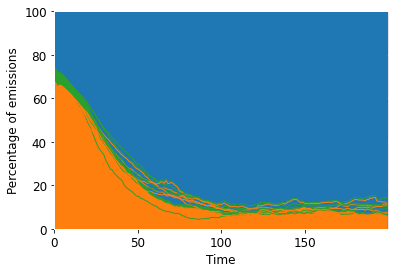

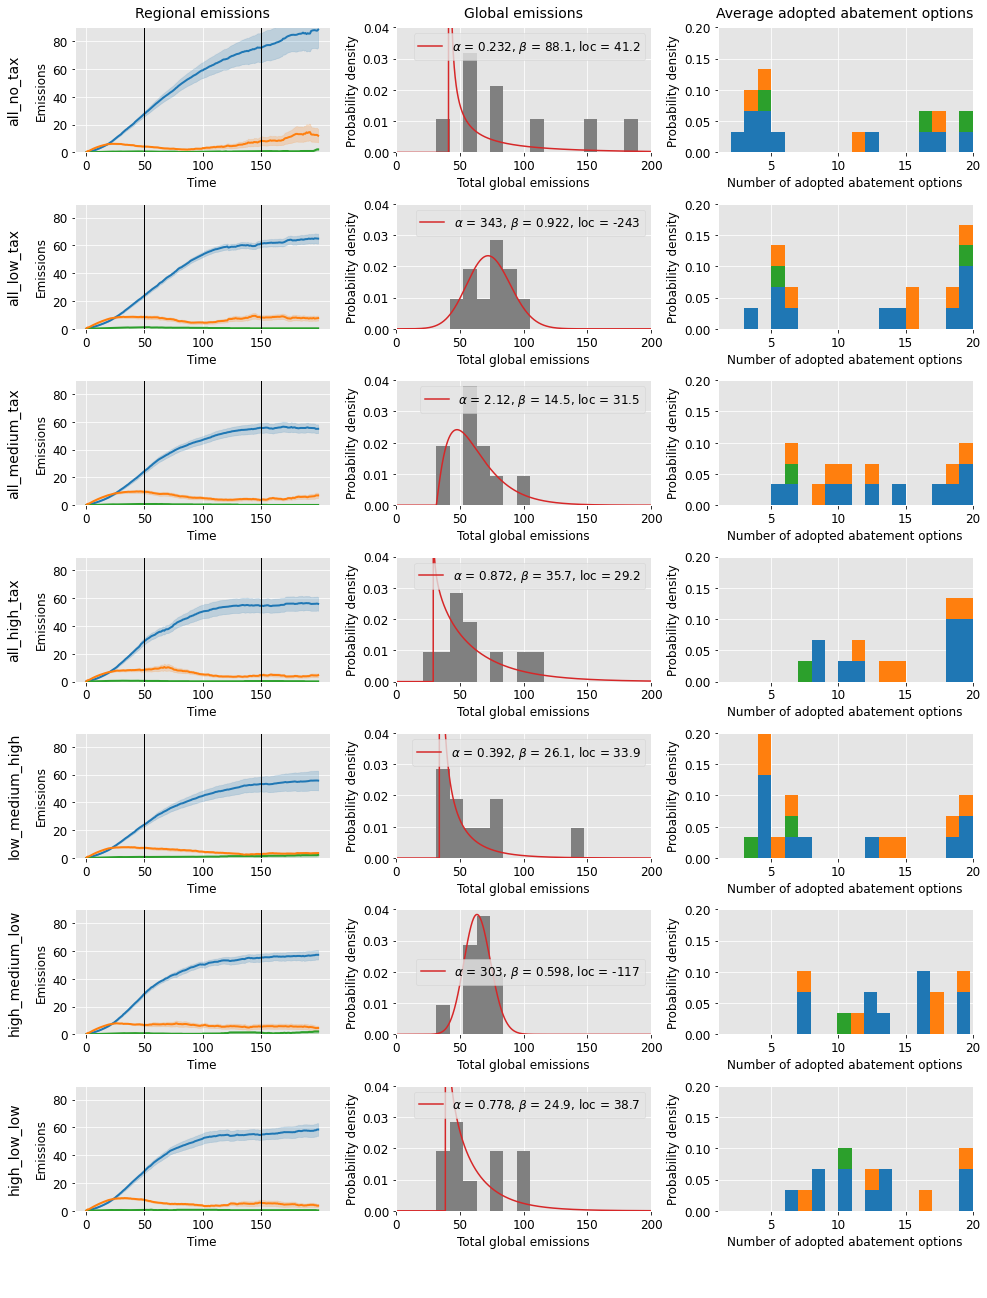

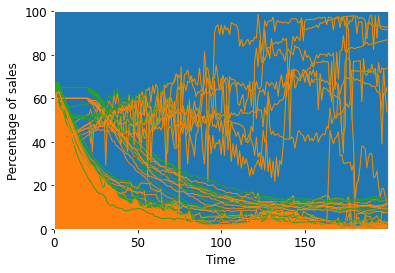

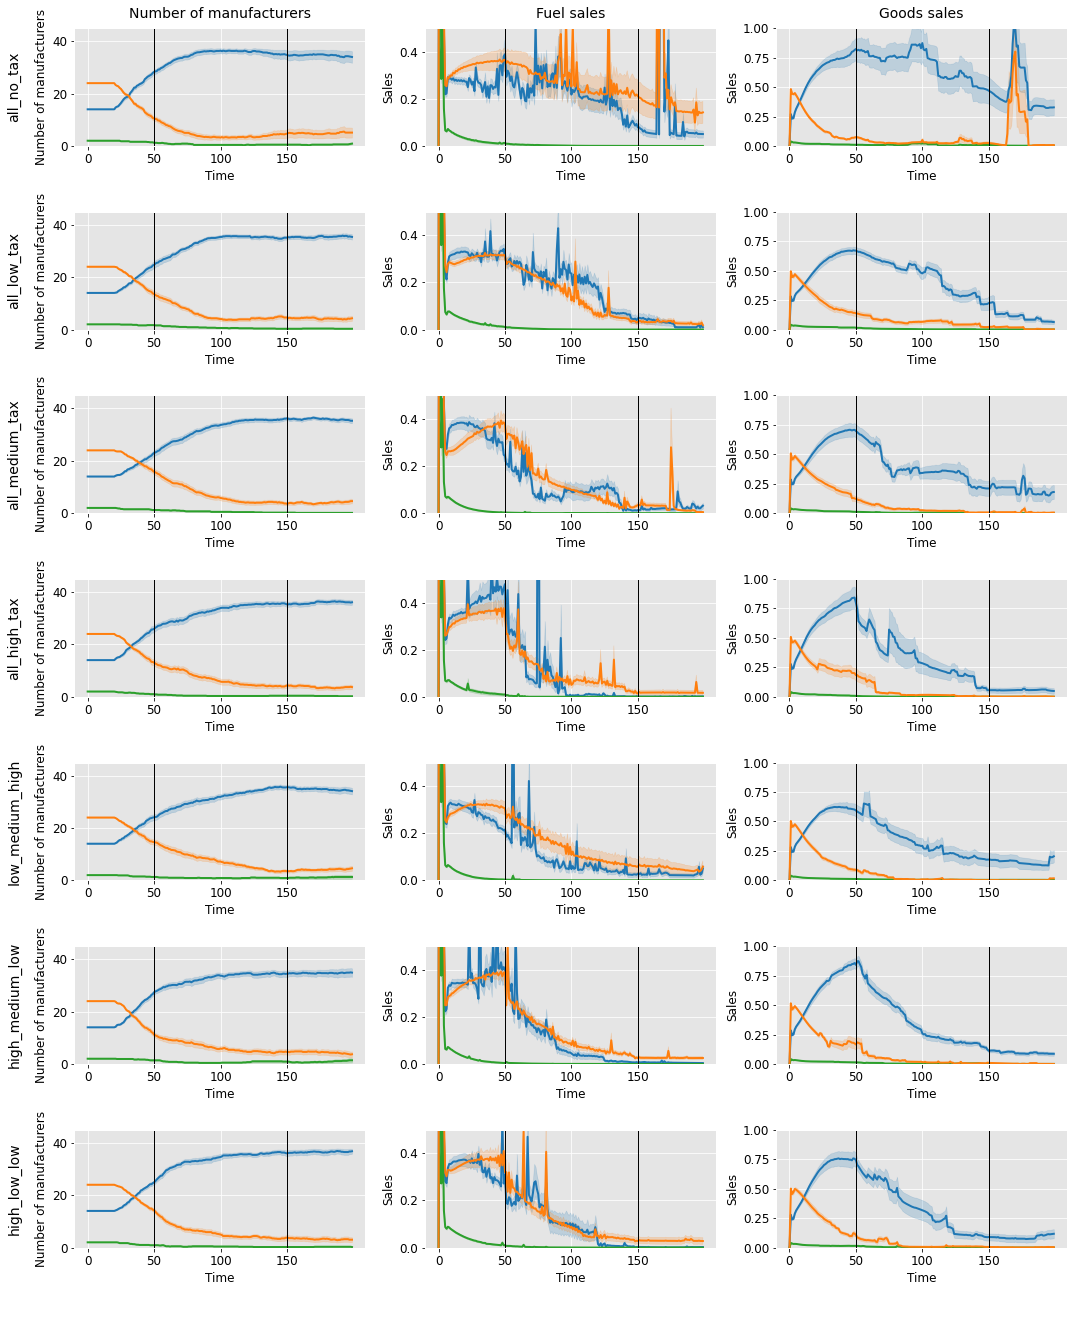

In [20]:
allData = getData()

getPlots1(allData[0], allData[1], allData[6])
getPlots2(allData[4], allData[2], allData[3])

plt.tight_layout()
plt.show()

# Sensetivity Analysis

In [21]:
sa_p_base = {
    'num_ecos': 3,
    'steps': 200,
    't_start': 50,
    't_impl': 100,
    'ql_d' : 0.1,
    'N_ld': 20,
    'num_s':[12, 6, 22],
    'num_m':[14, 2, 24],
    'eps': 0.00001,
    'g': 5.0,
}

sa_scenarios = {
    'all_no_tax': [tax_policies['no_tax'], tax_policies['no_tax'], tax_policies['no_tax']],
    'all_low_tax': [tax_policies['low_tax'], tax_policies['low_tax'], tax_policies['low_tax']]
}

sa_param_range = { 
    'num_vars': 3,
    'names': ['ld', 'xi', 'gamma'],
    'bounds': [
               [0.5, 0.9],      #6 - Abatement potential
               [0.8, 1.0],      #7 - Maximum relocation probability
               [0.005, 0.035],  #8 - Relocation probability scaling factor
               ]     
}    

sa_p_variable = {
    'dA_0' : [[0.1, 0.3],  [0.1, 0.3],  [0.1, 0.5]],
    'dB_0' : [[0.1, 0.3],  [0.1, 0.3],  [0.1, 0.5]],
    'A_0' : [0.8, 1.2, 1.0],
    'B_0' : [1.2, 0.8, 1.0],
    'D_0': [2.0, 0.4, 1.0],
    'D_SM_0': 0.0,
    'kappa_0_S' : 0.1,
    'kappa_0_M' : 0.1,
    't_delay': 5,
    't_stay': 15,
    'y': 5.0,
    'zeta': 0.015,
    'vartheta': 0.3,
    'tau': 6,
    'mu': 0.45,
    'chi_S': 0.3,
    'chi_M': 0.3,
    'epsilon_0': 15.0,
    'eta': 0.3,
    'beta_params': [[3-np.sqrt(2), 3+np.sqrt(2)], [4, 4], [3+np.sqrt(2), 3-np.sqrt(2)]],
}

sa_all_parameters = {**sa_p_base, **sa_p_variable}

measures = ['sE_G', 'e_sum_1','e_sum_2','e_sum_3', 'aP_M_1', 'aP_M_2', 'aP_M_3', 'psi_S_1', 'psi_S_2', 'psi_S_3', 'psi_M_1', 'psi_M_2', 'psi_M_3', 'aX_M_1', 'aX_M_2', 'aX_M_3']

In [22]:
np.random.seed(0)

for scenario in sa_scenarios:
    df = pd.DataFrame(columns=measures)
    param_values = saltelli.sample(sa_param_range, SA_SAMPLE_SIZE, calc_second_order=False)
    
    for param_value in tqdm(param_values):
        with io.capture_output() as captured:
            params = gen_dynamic_params_multi(scenario, sa_all_parameters, sa_param_range)
            for idx, name in enumerate(sa_param_range['names']):
                params[name] = param_value[idx]
            custom_output = {}
            model = Model(params,run_type="SA")
            results = model.run()
            data = results.variables.Model.iloc[-1]
            if sum(data['eco_sQ_S']) == 0:
                data['eco_sQ_S'] = [0, 0, 0]
            else: data['eco_sQ_S'] = [x / sum(data['eco_sQ_S']) for x in data['eco_sQ_S']]
            if sum(data['eco_sQ_M']) == 0:
                data['eco_sQ_M'] = [0, 0, 0]
            else: data['eco_sQ_M'] = [x / sum(data['eco_sQ_M']) for x in data['eco_sQ_M']]
            data_list = list(np.concatenate(data.tolist()).flat)
            filtered_data = data_list[2:9] + data_list[12:21]
            df.loc[len(df)] = filtered_data

    df.to_csv(f"{VIZ_PATH}SA_{scenario}.csv")

<ipython-input-22-b9b832aa8957>:5: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(sa_param_range, SA_SAMPLE_SIZE, calc_second_order=False)
100%|██████████| 80/80 [06:05<00:00,  4.57s/it]


In [ ]:
for scenario in sa_scenarios:
    df = pd.read_csv(f"{VIZ_PATH}SA_{scenario}.csv", index_col=0)

    Si = []    
    for measure in measures:
        y = np.array(df[measure])
        Si.append(sobol.analyze(sa_param_range, y))

    style.use('fivethirtyeight')

    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (15, 7.5)
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8

    for i in range(len(sa_param_range['names'])):
        y = [S1['S1'][i] for S1 in Si]
        c = 1/(len(measures) + 1)
        x = [j + c * i for j in range(len(y))]
        ax.errorbar(x, y, linestyle='', marker='.', label= sa_param_range['names'][i]) 

        ax.set_yticks(list(np.arange(-0.15, 0.1, 0.025)))
        ax.set_xticks(list(range(len(y))))
        ax.set_xticks([x + 0.5 for x in range(len(y) - 1)], minor = True)
        ax.grid(color='white', axis='x')
        ax.grid(color='black', linestyle='-', which='minor', axis='x')

    ax.set_ylabel('First order indices')
    ax.set_xlabel('Metrics')
    ax.set_xticklabels(measures)
    ax.legend(loc='lower right', ncol=3)

    if scenario == 'all_no_tax':
        plt.title('Sensitivity analysis for no tax scenario')
    else: plt.title('Sensitivity analysis for low tax scenario')
    
    plt.savefig(f"{VIZ_PATH}SA_{scenario}.png", dpi=300)